# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        #print(line)
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        #print(line)
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

print("Data size=",X.shape)
print("Label size=",Y.shape)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print('Training Data shape=',train_data.shape)
print('Test Data shape=', test_data.shape)

Data size= (8124, 126)
Label size= (8124,)
Training Data shape= (7000, 126)
Test Data shape= (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

____________________________________________________________________________________
|   k|Variance Explained by kth feature|Fraction of total variance explained till k|
------------------------------------------------------------------------------------
|   1|                          0.16404|                                    0.16404|
|   2|                          0.13323|                                    0.29728|
|   3|                          0.10173|                                    0.39901|
|   4|                          0.07063|                                    0.46965|
|   5|                          0.03867|                                    0.50831|
|   6|                          0.03681|                                    0.54512|
|   7|                          0.03128|                                    0.57640|
|   8|                          0.02734|                                    0.60374|
|   9|                          0.02616|                         

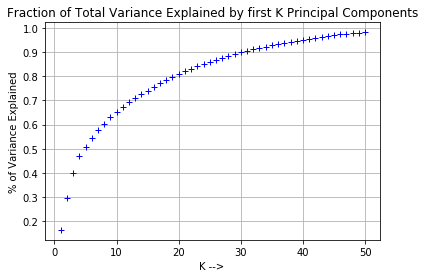

In [4]:
def get_pca_variance_ratio(x_data, k):
    """ Gets variance explained by 'k' component 
        Principal Component Analysis (PCA) on given input data 
        
        Args:
            x_data: Data on which PCA needs to run
            k: number of components in PCA 
                i.e. first 'k' principal components remain for further calculation
        Returns:
            array, variance ration explained by the first k principal components 
            on given data
    
    """
    pca = PCA(n_components=k)
    pca.fit(x_data)
    evr = pca.explained_variance_ratio_
    return evr

def calculate_print_pca(x_data, max_k):
    """ Calculates and Prints % of variance explained by range of 'k' component 
        Principal Component Analysis (PCA) on given input data 
        
        Args:
            x_data: Data on which PCA needs to run
            max_k: max k for which PCA needs to be run. So the range for k is 1 to max_k
        Returns:
            List of total variance explained by PCA for each set of first 'k' components
            where k ranges from 1 to max_k. Hence the returned list os of size max_k
    
    """
        
    variance_ratios = []
    k_range = range(1,max_k+1)
    
    # print table header
    print("_"*84)     
    print("|   k|Variance Explained by kth feature|Fraction of total variance explained till k|")  
    print("-"*84)  
    
    #print table rows
    evr = get_pca_variance_ratio(x_data, max_k)
    for k in k_range:
        evr_sum = sum(evr[:k])
        print("|{:4}|{:33.5f}|{:43.5f}|".format(k, evr[k-1], evr_sum))  
        variance_ratios.append(evr_sum)
    
    #print table footer
    print("-"*84) 
    return variance_ratios


    
def plot_pca(variance_ratios):
    """ Plots % of variance explained by range of PCA component sizes.
        
        Args:
            variance_ratios: List of fractions corrsponding to each value of n_components 
                parameter to PCA run
        Returns:
            None, plots the graph
    
    """
    k_range = range(1,len(variance_ratios)+1)
    plt.plot(k_range,variance_ratios,'b+')
    plt.title('Fraction of Total Variance Explained by first K Principal Components')
    plt.xlabel('K --> ')
    plt.ylabel('% of Variance Explained')
    plt.grid(True)
    plt.show()
    


variance_ratios = calculate_print_pca(train_data, 50)
plot_pca(variance_ratios) #extra, can be commented if not required

As we can see in the table, first component explains maximum variance of 16%. From then on each component brings lesser and lesser variance explanation. First 31 components explain just abive 90% variance in our training data.
Same cal also be seen from the graph, the jump between each point gets lesser and lesser and curve flatterns out as we approach higher k.

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

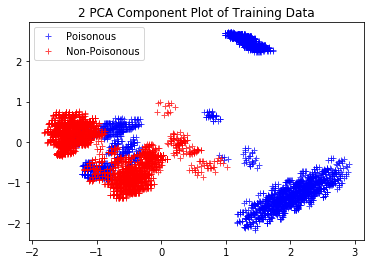

In [5]:
def transform_pca(x_data, k):
    """ Fits and Transforms given data using 'k' components Principal Components Analysis
        
        Args:
            x_data: Data to be transformed using PCA
            k: number of principal components to be kept in PCA post transformation
        Returns:
            2-d numpy array, Transformed version of x_data. Hence number of rows in return 
            array will be same as x_data whereas return array will have 'k' columns
    
    """
    pca = PCA(n_components = k,copy = True)
    x_trans = pca.fit_transform(x_data)
    return x_trans



def transform_2d_plot(x_data, x_labels):
    k = 2
    x_trans = transform_pca(x_data,k)
    
    x_trans_poisonous = x_trans[x_labels==1,:]
    x_trans_non_poisonous = x_trans[x_labels==0,:]
    
    ax = plt.subplot(111)
    ax.plot(x_trans_poisonous[:,0], x_trans_poisonous[:,1], 'b+', alpha=0.7, label = ('Poisonous'))
    ax.plot(x_trans_non_poisonous[:,0], x_trans_non_poisonous[:,1], 'r+', alpha=0.7, label = ('Non-Poisonous'))

    ax.set_title('2 PCA Component Plot of Training Data')
    ax.legend()
    plt.show()


transform_2d_plot(train_data, train_labels)    

There is relatively clear clustring of Poisonous and non poisonous mashrooms with just 2 features. 

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

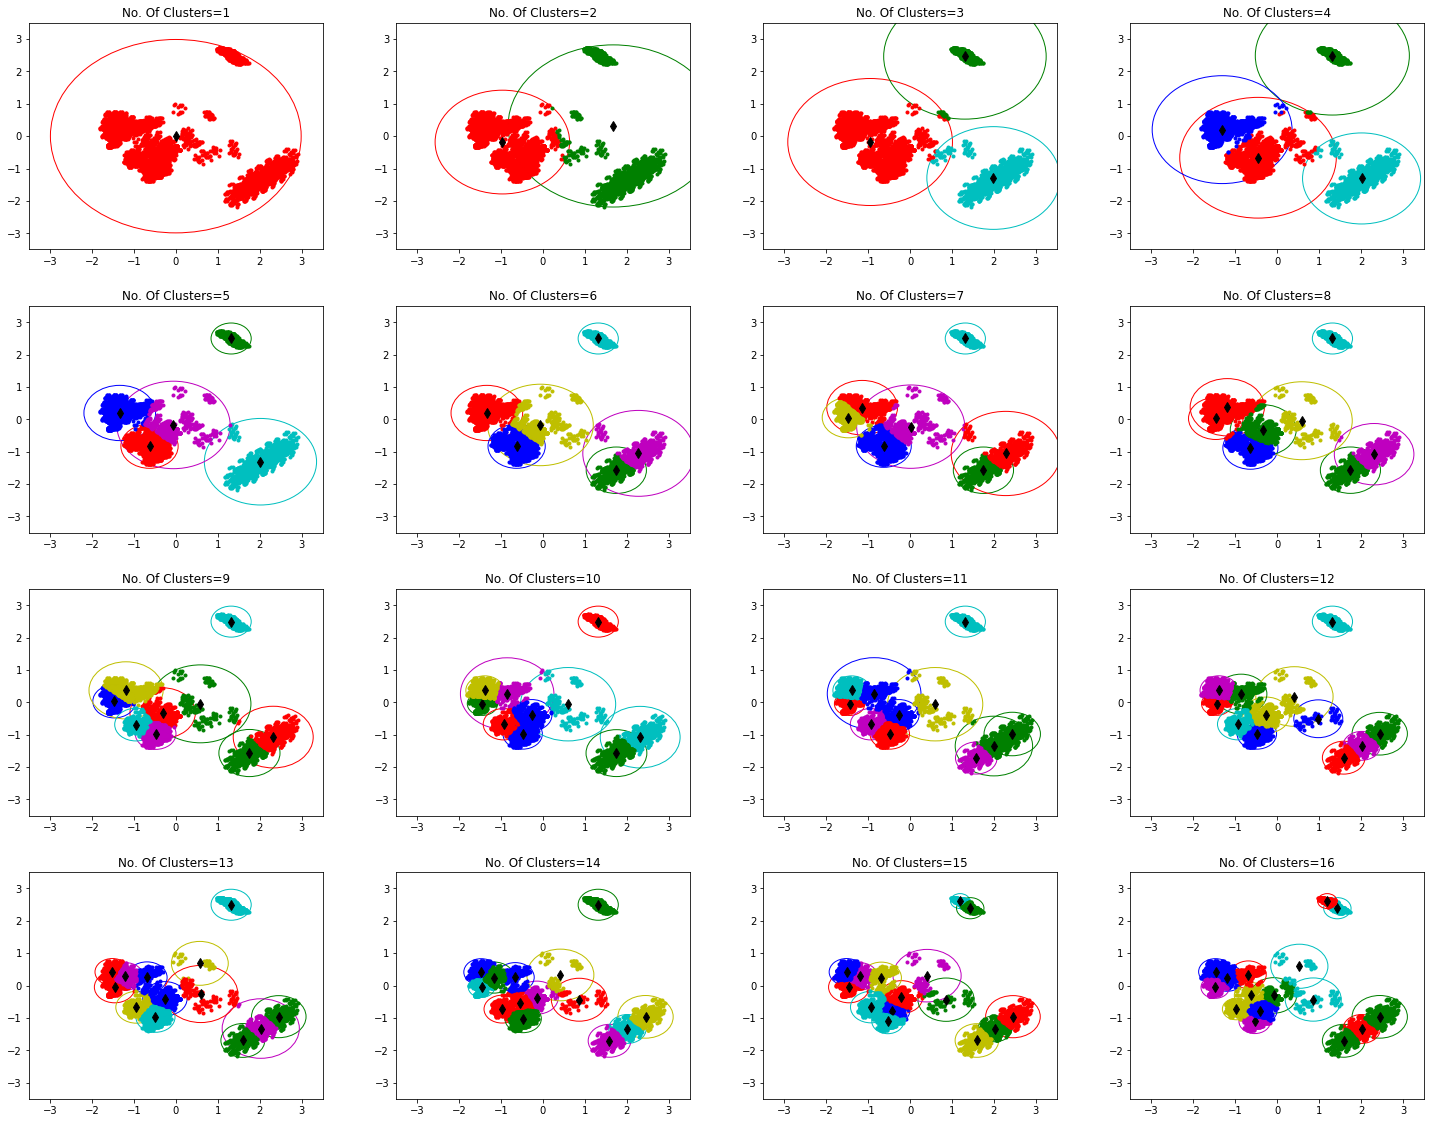

In [6]:
def calculate_point_distance(p1, p2):
    """ Calculates distance between two points. 
        Both points are represented as list of x and y co-ordinates
        
        Args:
            p1: First point which is a list of two decimal numbers 
                corresponding to it's x and y co-ordinates
            p2: Second point which is a list of two decimal numbers 
                corresponding to it's x and y co-ordinates
        Returns:
            number, it is distance between two points calculated as 
            sqrt((x1-x2)^2 + (y1-y2)^2)
    
    """
    x = (p1[0] - p2[0])
    y = (p1[1] - p2[1]) 
   
    d = x**2 + y**2
    d = d ** (1/2)
    
    return d

#print(calculate_point_distance([ 0.72029813 ,3.42412069],[1.66533454e-16, 2.16493490e-16]))

def get_farthest_point_from_centroid(cluster_point_list, centroid_point):
    """ Calculates distance from centroid for each point in the cluster
        And find the farthest point
        
        Args:
            cluster_point_list: List of points in given cluster
            centroid_point: Centroid point of the given cluster
        Returns:
            Array, 1-d array corresponds to the farthest point from centroid in given cluster.
                The array corresponds to x,y co-ordinates
    
    """
    distances_from_centroid = [calculate_point_distance(point,centroid_point) 
                               for point in cluster_point_list]
    return max(distances_from_centroid)

def transform_2pca_kmeans(x_data, x_labels, max_clusters):
    """ Transforms the input data using 2 component PCA 
        and then runs KMeans to group data points into various number of clusters 
        up max_clusters clusters.
        Then it plots all the data point along with centroids of clusters
        and draws circle from centroid to farthest point in respective clusters.
        
        Args:
            x_data: Input Mashroom data points on which PCA and KMeans algorithms are executed
            x_labels: Labels corresponding to x_data. 
                These are used to distinguish between poisonous and non poinsonous mashrroms.
            max_clusters: Maximum number of clusters to be made in KMeans algorithm.
        Returns:
            None, Plots the data poinsta dn clusters
    
    """
    cluster_range = range(1,max_clusters+1)
    
    k=2
    x_trans=transform_pca(x_data,k)
    
    x_trans_poisonous = x_trans[x_labels==1,:]
    x_trans_non_poisonous = x_trans[x_labels==0,:]    
    
    colors = 10 * ['r', 'g', 'c', 'b', 'm', 'y']
    #print(colors)
    
    no_of_plots_per_row = 4
    fig = plt.figure(figsize=(25,25))
    
    fig.subplots_adjust(hspace = .25) #height between subplots
    fig.subplots_adjust(wspace = .25) #width between subplots
    
    for num_of_clusters in cluster_range:
        #print('Running for {} clusters'.format(num_of_clusters))
        km = KMeans(n_clusters = num_of_clusters) #n_jobs=-1, max_iter=50, n_init=1,precompute_distances=True
        #print(km) 
        km = km.fit(x_trans)
        cluster_centers=km.cluster_centers_
        cluster_label=km.labels_
        #print(cluster_centers)
        #print(cluster_label)
        #print('KMeans executed for {} clusters'.format(num_of_clusters))
        
        ax = fig.add_subplot((int)(max_clusters/no_of_plots_per_row)+1
                             ,no_of_plots_per_row,num_of_clusters)    
        ax.set_xlim([-3.5,3.5])
        ax.set_ylim([-3.5,3.5])

        for cluster in range(num_of_clusters):
            #print(cluster)
            x_trans_cluster = x_trans[cluster_label==cluster]
            centroid = cluster_centers[cluster,:]
            farthest_distance = get_farthest_point_from_centroid(x_trans_cluster,centroid)
            #print(farthest_distance)
            cluster_circle=plt.Circle(centroid,farthest_distance, color=colors[cluster], fill=False)
            

            
            ax.plot(x_trans_cluster[:,0], x_trans_cluster[:,1], colors[cluster] + '.')            
            ax.plot(centroid[0], centroid[1], 'kd', markersize=7)
            ax.add_artist(cluster_circle)
            
        ax.set_title('No. Of Clusters={}'.format(num_of_clusters))
        
        
transform_2pca_kmeans(train_data, train_labels,16)       
        

Here we see that in some cases circle of one cluster encapsulates other cluster partially or fully. This happens because not all points in one cluster are equidistant from the centroid. 

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

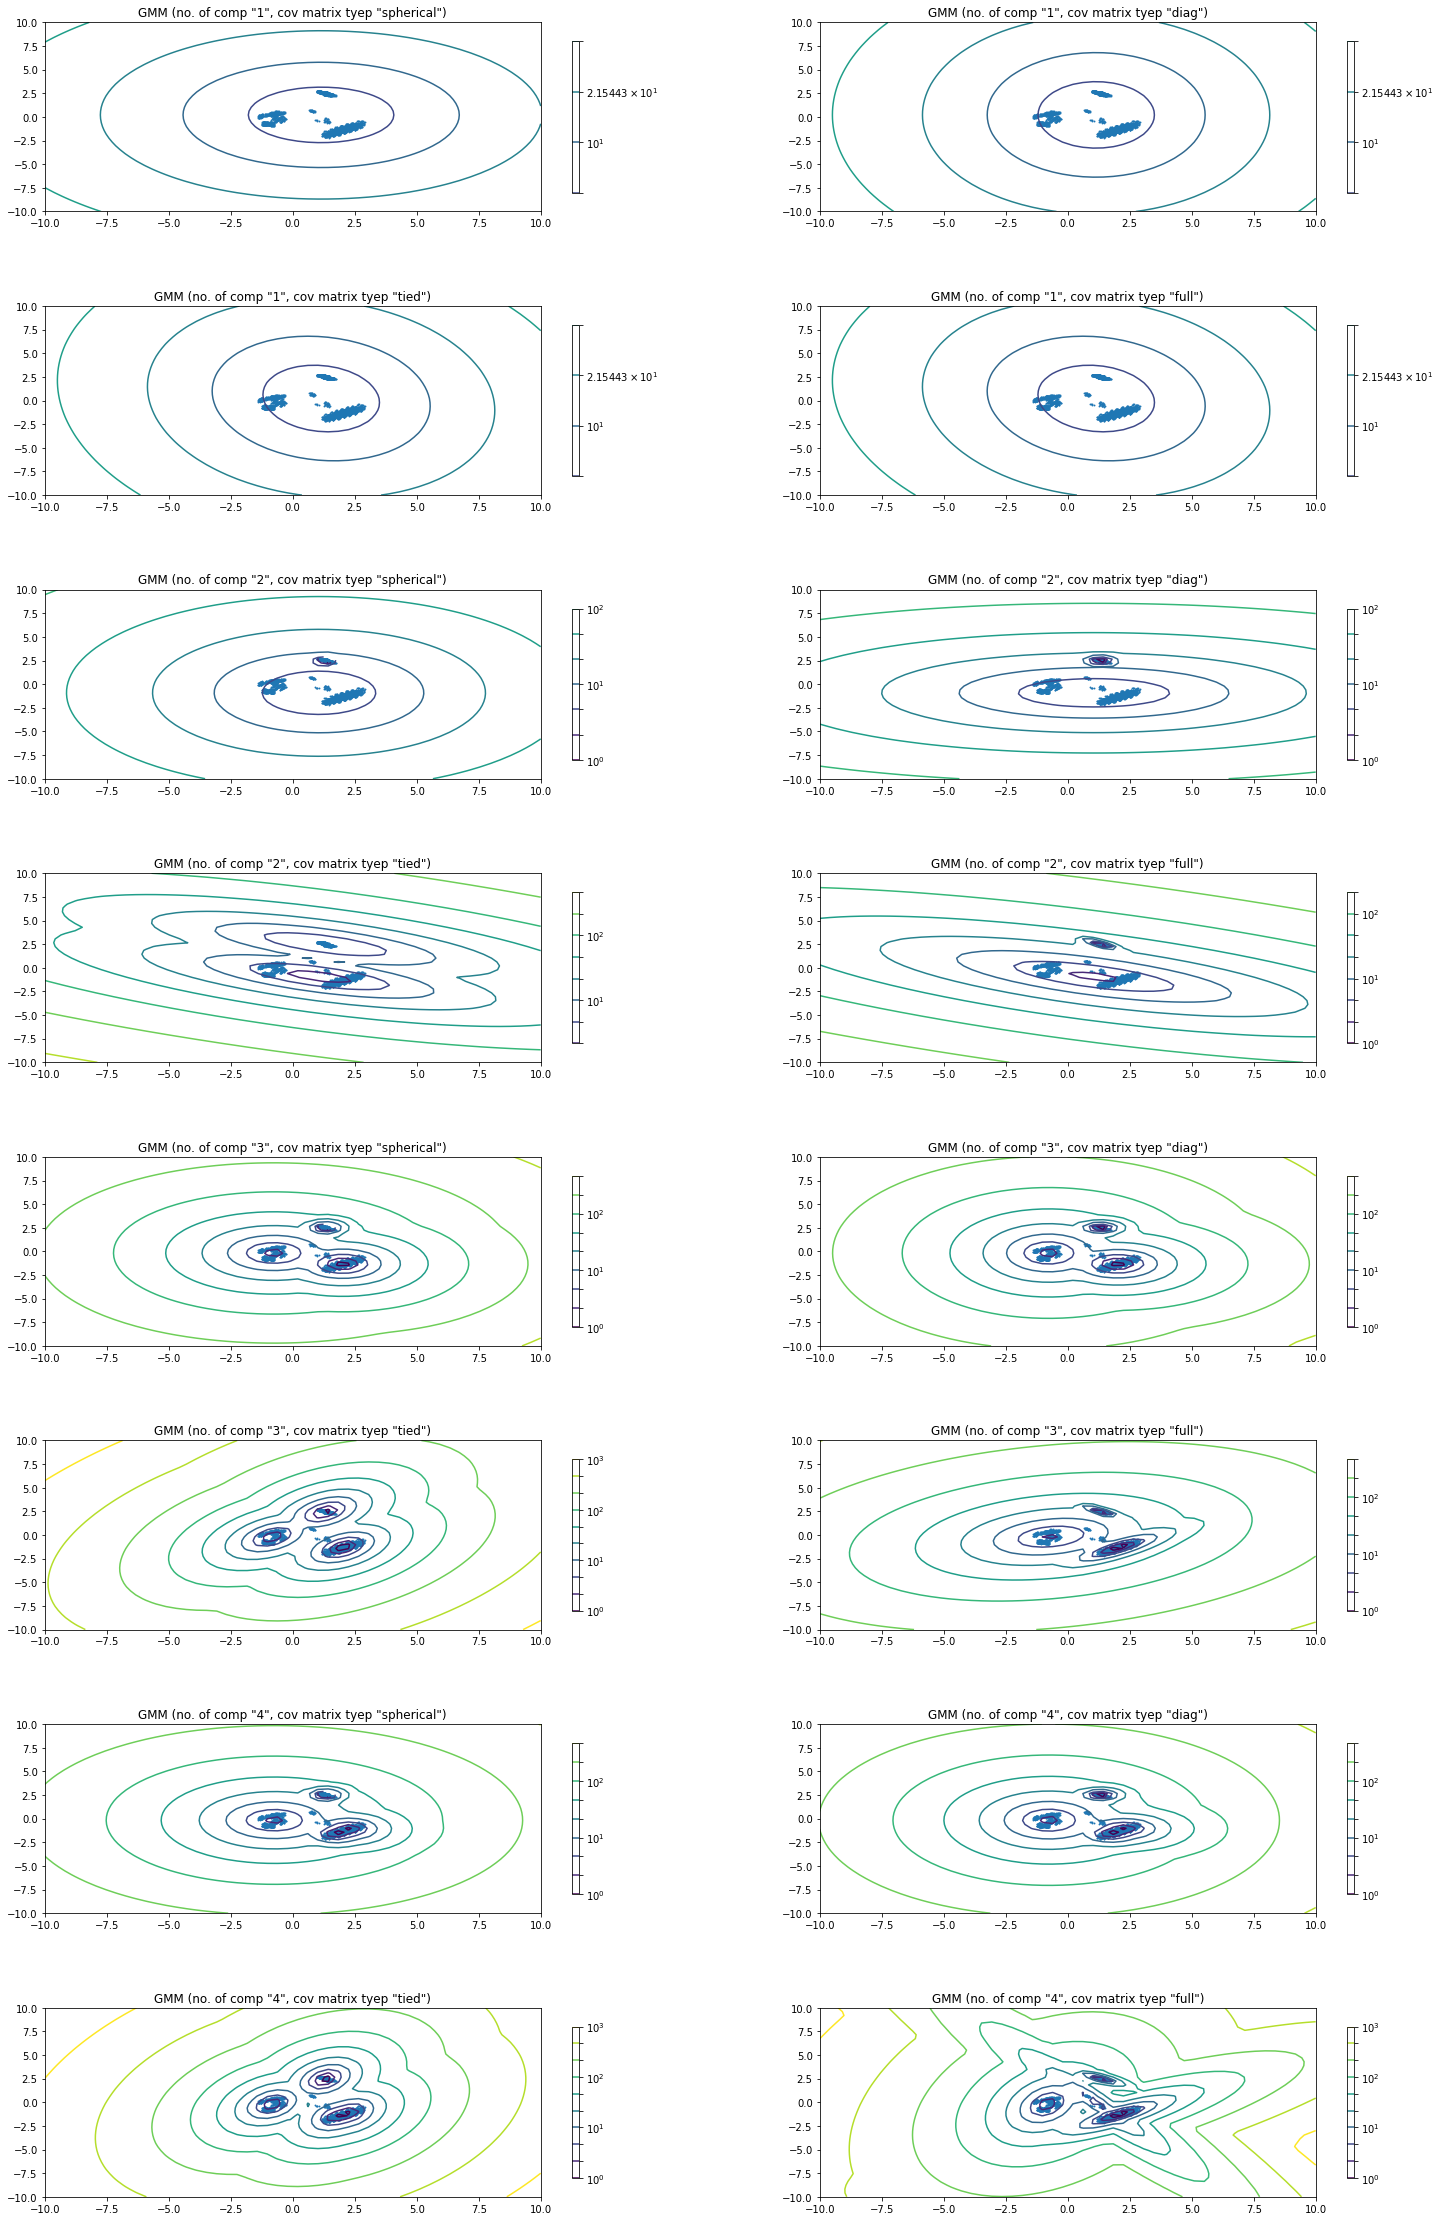

In [7]:
def get_covariance_matrix_types():
    """ Returns GMM Covariance Matrix type list
        
        Returns:
            list, Returns static list of 4 GMM Covariance Matrix types
    
    """
    types = ['spherical', 'diag', 'tied', 'full'] 
    return types

def get_gmm_fit(x_data, gmm_components, gmm_covariance_type):
    """ Instantiates GMM classifier with given number of components and 
        covariance matrix type and then gits the given data into the model
        
        Args:
            x_data: Data to be fit in GMM 
            gmm_components: number of components in GMM 
            gmm_covariance_type: GMM Covariance matrix type. 
                One of the 4 values returned by get_covariance_matrix_types function            
            
        Returns:
            GMM, GMM model fit over the x_data for given number of components 
                and covariance matrix type is returned 
    
    """    
    gmm = GMM(n_components=gmm_components, covariance_type = gmm_covariance_type)
    gmm.fit(x_data)
    return gmm;

def plot_gmm(gmmClf, x_data, no_of_comp, cov_mat_type, ax, fig):
    """ Plots GMM estimate contours with 2D underlying data
        
        Args:
            gmmClf: GMM classifier which is already fit over x_data
            x_data: Underlying data on which GMM is fitted. 
                x_data needs to be 2-D for plotting to work
            no_of_comp: Number of GMM components
            cov_mat_type: GMM Covariance Matrix type
                One of the 4 values returned by get_covariance_matrix_types function   
            ax: Axes object of the subplot.
            fig: Figure object of main plot.
            
        Returns:
            None, Plots GMM estimate contours with 2D underlying data
    
    """
    
    x = np.linspace(-10., 10.)
    y = np.linspace(-10., 10.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmmClf.score_samples(XX)[0]
    #print('Z=',Z)
    Z = Z.reshape(X.shape)

    CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = fig.colorbar(CS, shrink=0.8, extend='both', ax=ax)
    ax.scatter(x_data[:, 0], x_data[:, 1], .8)

    ax.set_title('GMM (no. of comp "{}", cov matrix tyep "{}")'
             .format(no_of_comp, cov_mat_type))
    ax.axis('tight')
    #plt.show()
    
def run_gmm(x_data, x_labels, max_components, max_cov_mat_types):
    """ Run Gaussian Mixture Model for various combnations of no of components 
        and covariaance matrix type for given data
        
        Args:
            x_data: Data on which various GMM combinations will be run
            x_labels: Labels for the x_data to identify poisonous samples
            max_components: MAximum number of components to be tried in GMM
            max_cov_mat_types: Maximum number of covariance matrix types to be tries in GMM
                The actial list of matrix types will be taken from get_covariance_matrix_types
            
        Returns:
            None, Plots GMM estimate contours with 2D underlying data for 
            various GMM runs using combinations of number of componnts and covariance matrix type
    
    """
    
    cov_mat_types = get_covariance_matrix_types()
    x_trans=transform_pca(x_data,2) 
    x_trans_poisonous = x_trans[x_labels==1,:]
    
    fig = plt.figure(figsize=(25,40))
    fig.subplots_adjust(hspace = .5) #height between subplots
    fig.subplots_adjust(wspace = .25) #width between subplots
    
    subplot_counter = 1
    no_of_subplots_per_row = 2;
    total_subplots = max_components*max_cov_mat_types
    no_of_rows_in_plot=total_subplots/no_of_subplots_per_row
    
    # add extra row of subplots if the number of subplots do not fill the row
    if total_subplots%no_of_subplots_per_row > 0:
        no_of_rows_in_plot = no_of_rows_in_plot + 1 
    
    for no_of_comp in range(1,max_components+1):        
        for mat_index in range(max_cov_mat_types):
            cov_mat_type = cov_mat_types[mat_index]
            #print('Running GMM for no of components "{}" with covariance matrix type "{}"'
                  #.format(no_of_comp,cov_mat_type))
            
            gmm = get_gmm_fit(x_trans_poisonous, no_of_comp, cov_mat_type)            

            ax = fig.add_subplot(no_of_rows_in_plot,no_of_subplots_per_row,subplot_counter)
            plot_gmm(gmm, x_trans_poisonous, no_of_comp, cov_mat_type,ax, fig)
            subplot_counter+=1
            
            
import warnings
warnings.filterwarnings('ignore')
run_gmm(train_data, train_labels, 4,4)   
    

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def get_gmm_score_for_label(x_train_data_trans, x_labels, label, x_test_data_trans, n_components
                            , covariance_type):
    """ Filters Training data for given label and 
        then runs n_components GMM and returns score for test data set 
        
        Args:
            x_train_data_trans: Training Data set already transfromed using PCA
            x_labels: Labels for the x_data to identify given label samples
            label: Label (1 or 0) to filter traiing data on
            x_test_data_trans: Test data set which is already transformed 
                using same PCA as Training Data set
            n_components: number of GMM components to be used
            covariance_type: Covariance matrix type to be used in GMM
            
        Returns:
            float, Returns GMM score for GMM model which is trained for a specific label
    
    """    

    x_train_trans_for_label = x_train_data_trans[x_labels==label,:]
    
    gmm = GMM(n_components=n_components, covariance_type = covariance_type)    
    gmm.fit(x_train_trans_for_label)       

    sc = gmm.score(x_test_data_trans)
    return sc;


def get_label_prediction_from_score(score_positive, score_negative):
    """ Given list of scores from positive and negative training set trained GMM models,
        predict the label for each test data
        
        Args:
            score_positive: list of score from positive label training set trained GMM model
            score_negative: list of score from negative label training set trained GMM model
            
        Returns:
            list, list of labels (1 or 0) indicating positive or negative label prediction
                for each of the test data
    
    """    

    predicted_labels = score_positive > score_negative
    predicted_labels = [1 if p else 0 for p in predicted_labels]
    return predicted_labels

def transform_pca_train_test(x_train_data, x_test_data, k):
    """ Fits and Transforms given training data using 'k' components Principal Components Analysis
        Then transforms test data using same PCA object
        
        Args:
            x_train_data: Training Data to be transformed using PCA
            x_test_data: Test Data to be transformed using PCA
            k: number of principal components to be kept in PCA post transformation
        Returns:
            tuple of 2-d numpy array, Transformed version of x_train_data and x_test_data. 
            Hence number of rows in returned tuple elements 
            array will be same as x_train_data and x_test_data respectively
            whereas return array will have 'k' columns
    
    """
    pca = PCA(n_components = k,copy = True)
    x_train_trans = pca.fit_transform(x_train_data)
    x_test_trans = pca.transform(x_test_data)
    return (x_train_trans,x_test_trans)

def get_prediction(x_train_data, x_train_labels, x_test_data
                                  , n_components = 4, covariance_type = 'full', k = 2):
    """ Transforms Training and Test data using 'k' PCA, then calculates individual score 
        using two GMM models, one with positive label and one with negative label training set.
        Then predict the label on test data by comparing GMM scores of two models.
        
        Args:
            x_train_data: Raw training data
            x_train_labels: Training data labels indicating poisonous or non poisonous mashrooms
            x_test_data: Test data for which label needs to be predicted
        Kwargs:
            n_components: GMM components to be used. Drfaults to 4
            covariance_type: GMM covariance type to be used. Defaults to 'full'
            k: first 'k' PCA components are kept. Defaults to 2       
            
        Returns:
            list, list of labels (1 or 0) indicating positive or negative label prediction
                for each of the test data
    
    """ 
    
    x_train_data_trans, x_test_data_trans = transform_pca_train_test(x_train_data, x_test_data, k) 
    
    score_positive = get_gmm_score_for_label(x_train_data_trans, x_train_labels, 1, x_test_data_trans,
                                            n_components, covariance_type)
    score_negative = get_gmm_score_for_label(x_train_data_trans, x_train_labels, 0, x_test_data_trans,
                                            n_components, covariance_type)

    predicted_labels = get_label_prediction_from_score(score_positive,score_negative)
    return predicted_labels

def get_print_classification(x_train_data, x_train_labels, x_test_data, x_test_labels):
    """ Gets prediction for test data using GMM model. 
        Then calculates performance of the prediction using ROC AUC score and prints it
        
        Args:
            x_train_data: Raw training data
            x_train_labels: Training data labels indicating poisonous or non poisonous mashrooms
            x_test_data: Test data for which label needs to be predicted   
            x_test_labels: Test data labels indicating poisonous or non poisonous mashrooms
            
        Returns:
            None, prints accurancy of the model using ROC AUC score
    
    """ 
    
    predicted_labels = get_prediction(x_train_data, x_train_labels, x_test_data)
    roc_auc = metrics.roc_auc_score(x_test_labels,predicted_labels)
    print('ROC AUC for 4 component full covariance matrix GMM is {:5.2}'.format(roc_auc))
    
n=None #use smaller value of n (say 100) for faster debugging else use None to run on full set
get_print_classification(train_data[:n,], train_labels[:n,], test_data[:n,], test_labels[:n,])

ROC AUC for 4 component full covariance matrix GMM is  0.96


Successfully identifying all poisonous mashrooms is critical but not at the expense of marking all non poinsonous mashrooms as poisonous. 
Hence we will use ROC AUC score to measure accuracy of our model. 

ROC AUC score of 4 component full covariance matrix GMM is  48% which is less than 50% random guess baseline accuracy. So there is lot of scope for improvement in this model.

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
class Stat_Holder:
    
    """ Class o hold statistics for each run of GMM.
        This class holds various attributes of GMM and the accuracy of predicted 
        value from that model.
    """
    
    def __init__(self, pca_component_no, gmm_component_no, cov_mat_type
                 , no_of_params, roc_auc): 
        """ Initializes instance of class with GMM attributes and accurancy score

            Args:
                pca_component_no: number of PCA components used in 
                    dimentionality reduction before GMM was run
                gmm_component_no: number of GMM components used in model
                cov_mat_type: GMM covariance matric type used in model
                no_of_params: Total number of model parameters used
                roc_auc: ROC AUC accurancy score of the model
        """
        self.pca_component_no = pca_component_no
        self.gmm_component_no = gmm_component_no
        self.cov_mat_type = cov_mat_type
        self.no_of_params = no_of_params
        self.roc_auc = roc_auc
        
    def __lt__(self, other):
        """ Compares one object of Stat_Holder to another object. 
            This method is used implicityly by sorting api.
            Current implementation would sort object i descending order of their roc_auc

            Args:
                other: other object to compare current object with

            Returns:
                boolean, True if roc_auc score of current object is greater than other object
                    False otherwise. If roc_auc matches then sort of no_of_params. smaller the better.
        """
        
        # sort decending by no_of_params if roc_auc matches
        if self.roc_auc == other.roc_auc:
            return self.no_of_params < other.no_of_params 
        else:
            return self.roc_auc > other.roc_auc # sort decending by roc_auc
        
    def __str__(self):
        """ Prints Stat_Holder object in readable format      

            Returns:
                None, prints all attributes of Stat_Holder class in readable format
        """
        return '{pca_component_no='+ str(self.pca_component_no) +\
                ' gmm_component_no=' + str(self.gmm_component_no) +\
                ' cov_mat_type=' + str(self.cov_mat_type) +\
                ' no_of_params=' + str(self.no_of_params) +\
                ' roc_auc=' + str(self.roc_auc) +\
                '}'
        
    def __repr__(self):
        """ Prints Stat_Holder object in readable format      

            Returns:
                None, calls __str__ function to prints all attributes of Stat_Holder 
                    class in readable format
        """
        return self.__str__()
# End of class Stat_Hlder    


def calculate_no_of_params(pca_component_no, gmm_component_no, cov_mat_type):
    """ Calculates number of parameters used by GMM model
        
        Args:
            pca_component_no: number of PCA components used in preprocessing data 
            gmm_component_no: number of components used in GMM model
            cov_mat_type: covariance matrix type used in GMM
            
        Returns:
            int, total number of parameters used by GMM model
    """
    if cov_mat_type == 'diag' :
        off_diag_param = 0
    else:
        off_diag_param = (pca_component_no ** 2 - pca_component_no) / 2
        
    no_of_params_per_comp =  off_diag_param + pca_component_no + pca_component_no  # diag + non diag
    no_of_params_per_gmm = no_of_params_per_comp * gmm_component_no # 
    
    no_of_params_across_classes = no_of_params_per_gmm * 2
    
    return int(no_of_params_across_classes)


def run_for_various_combination(x_train_data, x_train_labels, x_test_data, x_test_labels
                                ,max_pca_components, max_gmm_components, max_params):
    
    """ Run GMM for various combinations of PCA and GMM parameters and capture 
        number of parameters used by each gMM model and the accurancy of that model
        
        Args:
            x_train_data: Raw training data
            x_train_labels: Training data labels indicating poisonous or non poisonous mashrooms
            x_test_data: Test data for which label needs to be predicted   
            x_test_labels: Test data labels indicating poisonous or non poisonous mashrooms
            max_pca_components: MAximum number of PCA components to try
            max_gmm_components: Maximum number of GMM components to try
            max_params: MAx parameters to be allowed for GMM to run
            
        Returns:
            list, List of Stat_Holder objects each corersponding to 
            one run of GMM with one set of parameter combination
    """
    
    pca_component_range = range(1,max_pca_components+1)
    gmm_component_range = range(1,max_gmm_components+1)
    cov_mat_types = get_covariance_matrix_types()
    
    stats = []
    
    for no_of_pca_components in pca_component_range:
        for no_of_gmm_components in gmm_component_range:
            for cov_mat_type in cov_mat_types:    
                
                no_of_params = calculate_no_of_params(no_of_pca_components
                                                      , no_of_gmm_components
                                                      , cov_mat_type)
                #Current Param combination if yeilding more no of params allowed then skip
                if no_of_params > max_params:
                    continue 
                
                
                #print('''Executing GMM for {} pca components, {} covariance matrix type, {} 
                #         with GMM components totals to {} params. Skipped? {} '''
                #      .format(pca_component_no,cov_mat_type,gmm_component_no,no_of_params,more_than_50))
                
                predicted_labels = get_prediction(x_train_data, x_train_labels, x_test_data
                                                  , no_of_gmm_components, cov_mat_type, no_of_pca_components)
                roc_auc = metrics.roc_auc_score(x_test_labels,predicted_labels)
                sh = Stat_Holder(no_of_pca_components, no_of_gmm_components, cov_mat_type, no_of_params,roc_auc)
                stats.append(sh)
    
    return stats

n=None #use smaller value of n (say 100) for faster debugging else use None to run on full set    
stats = run_for_various_combination(train_data[:n,], train_labels[:n,], test_data[:n,], test_labels[:n,],20,20,50)

In [10]:
def sort_print_stats(stats):    
    """ Sorts in descending order of accuranct and prints stats in tabular format and plot the graph
        
        Args:
            stats: list fo Stat_Holder class objects each corersponding to 
            one run of GMM with one set of parameter combination
            
        Returns:
            None, prints and plots list of Stat_Holder class object list
    """    

    stats=sorted(stats)
    print_stats(stats)

def print_stats(stats):
    """ Prints stats in tabular format 
        
        Args:
            stats: list fo Stat_Holder class objects each corersponding to 
            one run of GMM with one set of parameter combination
            
        Returns:
            None, prints plots list of Stat_Holder class object list
    """ 
    print('{:^6}{:^12}{:^17}{:^20}{:^14}{:^10}'
          .format('Sr. No.','No. of PCA','No. of GMM Comp','Covariance Matrix','Total Params','ROC AUC'))
    print('_'*80)
    for index,stat in enumerate(stats):
        print('{:^6}{:^12}{:^17}{:^20}{:^14}{:>10.5}'
              .format(index+1,stat.pca_component_no,stat.gmm_component_no
                      ,stat.cov_mat_type,stat.no_of_params,stat.roc_auc))
sort_print_stats(stats)        

Sr. No. No. of PCA  No. of GMM Comp  Covariance Matrix   Total Params  ROC AUC  
________________________________________________________________________________
  1        2              5                full              50         0.96042
  2        2              4                full              40         0.95742
  3        2              5                diag              40         0.95672
  4        2              6                diag              48         0.95619
  5        2              3                diag              24          0.9534
  6        2              3                tied              30         0.95287
  7        2              4             spherical            40         0.95287
  8        2              3             spherical            30          0.9527
  9        2              4                tied              40         0.95024
  10       2              4                diag              32         0.94837
  11       5              1           

Successfully identifying all poisonous mashrooms is critical but not at the expense of marking all non poinsonous mashrooms as poisonous. 
Hence we will use ROC AUC score to measure accuracy of our model. 

Best GMM model under 50 parameters is 2 PCA and 2 GMM component full covariance matrix. That totals to 20 parameters with ROC AUC of about 88% which is much improvement than baseline 50% random guess and 48% 2-PCA 4 GMM components 'full' covariance matrix GMM accuracy which coincidently appears at the end of our list.

We also observe that diagonal convariance matrix is performing better on an average as we can see 7 out of top 10 are diagonal matrix GMM. Specially if we see entry number 5 : 2 PCA, Single GMM component with diagonal covariance matrix which toals to just 8 parameters performed well with 83.5% ROC AUC. Thats one of the best accurancy in we can see within single digit total number of parameters subset of GMM runs.